In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import pandas as pd

import statistics
from tqdm import tqdm
import numpy as np

import random

import os
import matplotlib.pyplot as plt

import time

In [2]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Dataset
# from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader

import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import sklearn
from math import sqrt
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Create train val and test data list

In [3]:
def prepare_list(x_folder, y_folder, adj_path, save_path):
    adj_df = pd.read_csv(adj_path)
    time_list = os.listdir(y_folder)
    train_list = []
    for time in time_list:
        x_name = 'Divided_' + time.split('_')[0] + '.csv'
        x_path = os.path.join(x_folder, x_name)
        y_path = os.path.join(y_folder, time)

        x_df = pd.read_csv(x_path)
        y_df = pd.read_csv(y_path)

        layer1_index = y_df[['Unnamed: 0']][y_df['1'] != -1]['Unnamed: 0'].values
        
        for index in layer1_index:
            new_line = [index, time]
            train_list.append(new_line)
    df_train = pd.DataFrame(train_list, columns=['node', 'time'])
    df_train.to_csv(save_path)

In [4]:
train_folder = r'../PreparedData/Y_time/good/Weekday/Train/' 
val_folder = r'../PreparedData/Y_time/good/Weekday/Val/'
test_folder = r'../PreparedData/Y_time/good/Weekday/Test/'
x_folder = r'../PreparedData/X/'
adj_path = r'../PreparedData/adjacentMatrix.csv'

train_save = r'../PreparedData/Y_time/good/Weekday/Train_list1.csv'
test_save = r'../PreparedData/Y_time/good/Weekday/Test_list1.csv'
val_save = r'../PreparedData/Y_time/good/Weekday/Val_list1.csv'

In [5]:
# prepare_list(x_folder, train_folder, adj_path, train_save)
# prepare_list(x_folder, val_folder, adj_path, val_save)
# prepare_list(x_folder, test_folder, adj_path, test_save)

### Create dataset

In [6]:
class TrafficDataset(Dataset):
    def __init__(self, path, dataFolder):
        super(TrafficDataset, self).__init__(None)
        self.path = path # data list csv file
        self.dataFolder = dataFolder # folder with y files
        
        self.dataLst = pd.read_csv(self.path)
        self.nodeLst = self.dataLst['node'].values.tolist()
        self.yLst = self.dataLst['time'].values.tolist()
        
        self.adj_df = pd.read_csv(r'../PreparedData/adjacentMatrix.csv')
        
        
        self.column_list = ['SVIID',
                            'StreetWidt', 'Length',  
                            'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
                            'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
                            'SocialServ', 'Transporta', 'Water',
                            'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
                            'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
                            'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
                            'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
                            'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
                            'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
                            'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
                            'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']
    def len(self):
        return len(self.nodeLst)
#         return 10
    
    def get_nodes(self, nodeLst):
        nxtLayer = nodeLst
        for node in nodeLst:
            idx_df = self.adj_df[self.adj_df['To'] == node]
            From = idx_df['From'].values
            nxtLayer = np.concatenate((nxtLayer, From))
        return nxtLayer
        
    @property
    def raw_file_names(self):
        return []
    
    def get(self, idx):
        node = self.nodeLst[idx]
        yName = self.yLst[idx]
        
        ly2 = list(set(self.get_nodes(np.array([node]))))
        ly3 = list(set(self.get_nodes(ly2)))
        ly4 = list(set(self.get_nodes(ly3)))
        ly3.remove(node)
        ly3.insert(0, node)

        year = yName.split('_')[0]
        x_name = 'Divided_' + year + '.csv'
        
        x_df = pd.read_csv(os.path.join(r'../PreparedData/X/', x_name))
        y_df = pd.read_csv(os.path.join(self.dataFolder, yName))
        
        # reconstruct x
        xLst = []
        for n in ly3:
            x = x_df[x_df['ID'] == n]
            xLst.append(x)
        x = pd.concat(xLst)
        
        # reconstruct adjacent matrix
        newID = list(range(x.shape[0]))
        x['newID'] = newID
        
        NF = x['NodeIDFrom'].values
        NT = x['NodeIDTo'].values
        ID = x['newID'].values
        
        adj_f = []
        adj_t = []
        
        for i in range(x.shape[0]):
            To = NT[i]
#             print(NT[i])
            df_To = x[x['NodeIDFrom'] == To]

            to = df_To['newID'].to_list()
            f = [ID[i]] * df_To.shape[0]

            adj_f = adj_f + f
            adj_t = adj_t + to
            
        # get edge for graph
        edge_index = torch.tensor([adj_f, adj_t], dtype=torch.long)
        
        # get x for graph
        graph_x = x[self.column_list].values
        
        image_x = []
        SVIIDList = x['SVIID'].values
        
#         start_time = time.time()
        
        for ID in SVIIDList:
            
#             start_time1 = time.time()
            rm_x = np.load(os.path.join(r'../RS/embedding/', str(ID) + '.npy')).reshape((1048576,))
#             end_time1 = time.time()
            
#             print('Processing remotesensing images: ', end_time1 - start_time1)
            Row_x = rm_x
            st_ns = [str(ID)+'_0.npy', str(ID)+'_90.npy', str(ID)+'_180.npy', str(ID)+'_270.npy']
            for st in st_ns:
                st_path = os.path.join(r'../SVI/embedding/', st)
                if os.path.exists(st_path):
                    st_x = np.load(st_path).reshape((1048576,))
                else:
                    st_x = np.zeros(rm_x.shape)
                Row_x = np.concatenate((Row_x, st_x))
            image_x.append(Row_x.tolist())
        image_x = np.array(image_x)
        graph_x = np.concatenate((graph_x, image_x), 1)   
        
#         end_time2 = time.time()
#         print('_______________totally used ————————————： ', end_time2 - start_time)
                
#         rm_x = 
        
        graph_x = torch.tensor(graph_x, dtype=torch.float)
        
        # get y for graph
        graph_y = y_df.iloc[node][1:]
        graph_y = graph_y * 156.377030788485 + 106.66053597731798
        graph_y_hr = []
        for i in range(0, 96-3, 4):
            new_data = graph_y[i:i+4].sum()
            graph_y_hr.append(new_data)
        graph_y = np.array(graph_y_hr)
#         graph_y = (graph_y - 557.0517126603728) / 597.3126488565076
        graph_y = torch.tensor(graph_y, dtype=torch.float)
        
        # construct graph
        data = Data(x=graph_x, edge_index=edge_index, y=graph_y)
        return data

In [7]:
train_dataset = TrafficDataset(train_save, train_folder)
test_dataset = TrafficDataset(test_save, test_folder)
val_dataset = TrafficDataset(val_save, val_folder)

In [8]:
training_dataloader = DataLoader(train_dataset, 
                                 batch_size=1, 
                                 shuffle=False, 
                                 num_workers=5)
validation_dataloader = DataLoader(val_dataset, 
                                 batch_size=1, 
                                 shuffle=False, 
                                 num_workers=5)
test_dataloader = DataLoader(test_dataset, 
                                 batch_size=1, 
                                 shuffle=False, 
                                 num_workers=5)

In [9]:
train_dataset[0].y

tensor([ 933.,  558.,  417.,  327.,  412.,  827., 1343., 1618., 1239., 1347.,
        1411., 1357., 1198., 1197., 1159., 1415., 1483., 1679., 1580., 1588.,
        1642., 1630., 1491., 1272.])

In [10]:
# i = 0
# for data in tqdm(training_dataloader):
#     a = 0

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.num_layers = 1
        
#         street view images features extraction
        self.svi1 = nn.Linear(256 * 64 * 64, 64)
        self.svi2 = nn.Linear(64, 128)
        self.svi3 = nn.Linear(128, 128)
        
#         remote sensing images features extraction
        self.rm1 = nn.Linear(256 * 64 * 64, 64)
        self.rm2 = nn.Linear(64, 128)
        self.rm3 = nn.Linear(128, 128)
        
#         road segment features extraction
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(512, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

#         self.lstm1 = nn.LSTM(5, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(64, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 56)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(56, 24)
        
#         self.act1 = nn.LeakyReLU(0.3)
        self.act1 = nn.Sigmoid()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index, t = data.x, data.edge_index, data.y
        
#         SVIID = x_all[:, 0].cpu().numpy()
#         for i in range(x_all.shape[0]):
#         # #     print(int(SVIID[i]))
#         # for i in range(2):
#             RMID = str(int(SVIID[i]))
#             data_path = os.path.join(r'../RS/embedding/', RMID+'.npy')
#             data = np.load(data_path)
#             x = torch.tensor(data).to(device)
#             x = torch.flatten(x)
#             x = self.rm1(x)
#             x = self.rm2(x)
#             x = self.rm3(x)
#             print(i)
        
        
        
        x_road = x_all[:, 1:3]
        x_location = x_all[:,3:16]
        x_se = x_all[:, 16:56]
        
        x_rm = x_all[:, 56:1048632]
        x_svi1 = x_all[:, 1048632:2097208]
        x_svi2 = x_all[:, 2097208:3145784]
        x_svi3 = x_all[:, 3145784:4194360]
        x_svi4 = x_all[:, 4194360:]
        
        
        
#         t = x_all[:, 56:].reshape((1, x_all.shape[0], 12))  
#         t = t[5:10].reshape((1, 1, 5))

        x_road = self.sep1(x_road)
        x_road = self.act1(x_road)
        x_road = self.sep4(x_road)
        x_road = self.act2(x_road)
        
        x_location = self.sep2(x_location)
        x_location = self.act1(x_location)
        x_location = self.sep5(x_location)
        x_location = self.act2(x_location)
        
        x_se = self.sep3(x_se)
        x_se = self.act1(x_se)
        x_se = self.sep6(x_se)
        x_se = self.act2(x_se)
        
        x_rm = self.rm1(x_rm)
        x_rm = self.act1(x_rm)
        x_rm = self.rm2(x_rm)
        x_rm = self.act2(x_rm)
        x_rm = self.rm3(x_rm)
        x_rm = self.act2(x_rm)
        
        x_svi1 = self.svi1(x_svi1)
        x_svi1 = self.act1(x_svi1)
        x_svi1 = self.svi2(x_svi1)
        x_svi1 = self.act2(x_svi1)
        x_svi1 = self.svi3(x_svi1)
        x_svi1 = self.act2(x_svi1)
        
        x_svi2 = self.svi1(x_svi2)
        x_svi2 = self.act1(x_svi2)
        x_svi2 = self.svi2(x_svi2)
        x_svi2 = self.act2(x_svi2)
        x_svi2 = self.svi3(x_svi2)
        x_svi2 = self.act2(x_svi2)
        
        x_svi3 = self.svi1(x_svi3)
        x_svi3 = self.act1(x_svi3)
        x_svi3 = self.svi2(x_svi3)
        x_svi3 = self.act2(x_svi3)
        x_svi3 = self.svi3(x_svi3)
        x_svi3 = self.act2(x_svi3)
        
        
        x_svi4 = self.svi1(x_svi4)
        x_svi4 = self.act1(x_svi4)
        x_svi4 = self.svi2(x_svi4)
        x_svi4 = self.act2(x_svi4)
        x_svi4 = self.svi3(x_svi4)
        x_svi4 = self.act2(x_svi4)
        
        x_svi = (x_svi1 + x_svi2 + x_svi3 + x_svi4)/4
        
        x = torch.cat((x_road, x_location, x_se, x_rm, x_svi), 1)
        
        x = self.conv1(x, edge_index)
        x = self.act2(x)
#         x = F.dropout(x, training=self.training) 

        x = self.conv2(x, edge_index)
        x = self.act2(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        x = self.conv3(x, edge_index)
        x = self.act2(x)
        x = F.dropout(x, training=self.training, p=0.1) 

#         h0 = torch.zeros(self.num_layers, 1, 64).requires_grad_().to(device)
#         c0 = torch.zeros(self.num_layers, 1, 64).requires_grad_().to(device)

#         _, (hn, _) = self.lstm1(t, (h0, c0))

#         t = hn[0]
#         x = torch.cat((x[0], t[0]))
        x = x[0]
        x = self.linear1(x)
        x = self.act2(x)
        x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = self.act2(x)
#         x = F.dropout(x)
        
        x = self.linear3(x)
#         x = self.act3(x)
        
        return x

In [12]:
def MAPE(pred, real):
    return torch.mean(torch.abs((pred - real)/real))

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = Net().to(device)
learning_rate = 0.001
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
# loss_function = MAPE()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
epoch = 100


train_loss_list = []
val_loss_list = []

train_loss_percentage_list = []
val_loss_percentage_list = []


for i in range(epoch):
    
    print('------------' + str(i) + '-------------')
    train_loss = []
    validation_loss = []
    train_loss_percentage = []
    validation_loss_percentage = []
    best = 100000000
    best_path = r'../Weights/best.pt'
    
    
    
    for batch in tqdm(training_dataloader):

        optimizer.zero_grad()
        batch.to(device)
        out = model(batch)
#         print(out)

#         l = loss_function(out, batch.y[10:])
        mask = batch.y != 0
        l = MAPE(out[mask], batch.y[mask])
        l.backward()
        optimizer.step()

        train_loss.append(l.tolist())
#         train_loss_percentage.append(l.tolist()/(batch.y[train_mask].mean().tolist()+0.000001)) 

    
    with torch.no_grad():
        for batch in validation_dataloader:
            batch.to(device)
            out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
            mask = batch.y != 0
            loss_val = MAPE(out_val[mask], batch.y[mask])
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)
    
            
            validation_loss.append(loss_val.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
                
    train_loss = np.array(train_loss)
#     train_loss_percentage = np.array(train_loss_percentage)

    train_loss = train_loss[~pd.isnull(train_loss)].tolist()
#     train_loss_percentage = train_loss_percentage[~pd.isnull(train_loss_percentage)].tolist()
    
    

    validation_loss = np.array(validation_loss)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_train_loss = sum(train_loss)/len(train_loss)
    average_val_loss = sum(validation_loss)/len(validation_loss)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)
#     average_val_loss_percentage = sum(validation_loss_percentage)/len(validation_loss_percentage)
    
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)
#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('Trainning loss is: ' + str(average_train_loss) + '    , validation loss is: ' + str(average_val_loss))
#     print('Trainning loss p is: ' + str(average_train_loss_percentage) + '    , validation p loss is: ' + str(average_val_loss_percentage))

    
    if average_val_loss < best:
        best = average_val_loss
        torch.save(model.state_dict(), best_path)
    if i%5 == 0:
        epoch_path = os.path.join(r'../Weights/', str(i) + '_2.pt')
        torch.save(model.state_dict(), epoch_path)

------------0-------------


100%|███████████████████████████████████████| 1000/1000 [11:27<00:00,  1.45it/s]


Trainning loss is: 1.0703835006885394    , validation loss is: 0.9532022373657112
------------1-------------


100%|███████████████████████████████████████| 1000/1000 [11:31<00:00,  1.45it/s]


Trainning loss is: 1.069787899618278    , validation loss is: 0.9580872497808046
------------2-------------


100%|███████████████████████████████████████| 1000/1000 [11:27<00:00,  1.45it/s]


Trainning loss is: 1.060704409165349    , validation loss is: 0.9645632937160776
------------3-------------


100%|███████████████████████████████████████| 1000/1000 [11:27<00:00,  1.46it/s]


Trainning loss is: 1.0114628037732685    , validation loss is: 0.9409746288413733
------------4-------------


100%|███████████████████████████████████████| 1000/1000 [11:29<00:00,  1.45it/s]


Trainning loss is: 1.0223916340208723    , validation loss is: 0.9091327014703386
------------5-------------


100%|███████████████████████████████████████| 1000/1000 [11:28<00:00,  1.45it/s]


Trainning loss is: 0.9378481427718977    , validation loss is: 0.9093354019960407
------------6-------------


100%|███████████████████████████████████████| 1000/1000 [11:29<00:00,  1.45it/s]


Trainning loss is: 0.9183138879631947    , validation loss is: 0.8920579355967116
------------7-------------


100%|███████████████████████████████████████| 1000/1000 [11:29<00:00,  1.45it/s]


Trainning loss is: 0.9122781874182707    , validation loss is: 0.8813909478710451
------------8-------------


100%|███████████████████████████████████████| 1000/1000 [17:41<00:00,  1.06s/it]


Trainning loss is: 0.8603535712004186    , validation loss is: 0.8720223564856968
------------9-------------


100%|███████████████████████████████████████| 1000/1000 [19:20<00:00,  1.16s/it]


Trainning loss is: 0.8711239734966912    , validation loss is: 0.8875602193521542
------------10-------------


100%|███████████████████████████████████████| 1000/1000 [19:13<00:00,  1.15s/it]


Trainning loss is: 0.8731503612352517    , validation loss is: 0.8566295294094853
------------11-------------


 88%|███████████████████████████████████▏    | 881/1000 [12:54<00:48,  2.48it/s]

In [23]:
out

tensor([ 0.0905, -0.0462, -0.1342, -0.0716,  0.0141,  0.1092, -0.0314, -0.0343,
        -0.0303,  0.0076, -0.0398, -0.1243, -0.1065,  0.0119,  0.1231, -0.0793,
        -0.0202,  0.1218, -0.0232, -0.0195,  0.0917,  0.0480,  0.0067, -0.1304],
       device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
batch.y

tensor([ 933.,  558.,  417.,  327.,  412.,  827., 1343., 1618., 1239., 1347.,
        1411., 1357., 1198., 1197., 1159., 1415., 1483., 1679., 1580., 1588.,
        1642., 1630., 1491., 1272., 1240.,  836.,  591.,  538.,  562.,  883.,
        1356., 1648., 1477., 1254., 1231., 1276., 1317., 1536., 1689., 1673.,
        1781., 1566., 1564., 1848., 1866., 1927., 1937., 1725.,  988.,  962.,
         830.,  605.,  699.,  888., 1070., 1059., 1089.,  977.,  921., 1006.,
         942., 1008., 1103., 1051., 1039.,  952.,  963., 1049.,  975., 1019.,
        1129., 1288.,  436.,  267.,  158.,  139.,  143.,  187.,  246.,  408.,
         588.,  580.,  546.,  646.,  596.,  559.,  582.,  618.,  524.,  616.,
         538.,  475.,  453.,  460.,  366.,  343.], device='cuda:0')

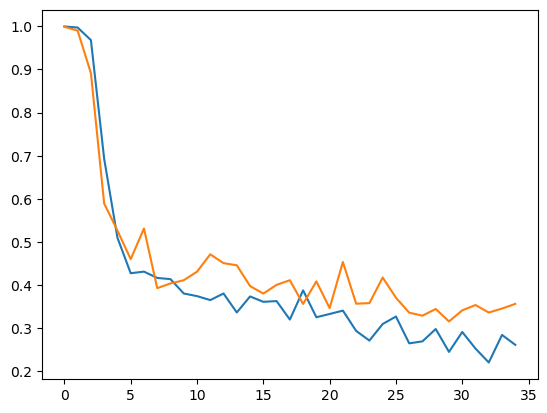

In [42]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

In [43]:
loss = {'training': train_loss_list, 'val':val_loss_list}

In [44]:
loss = pd.DataFrame(loss)

In [45]:
loss.to_csv(r'../Weights/loss.csv')

In [23]:
from torchmetrics import MeanAbsolutePercentageError

ModuleNotFoundError: No module named 'torchmetrics'

In [24]:
a = torch.tensor([1, 2, 3, 4])

In [29]:
b = torch.tensor([5, 6, 7, 0])

In [36]:
mean = torch.abs((a - b) / b )
mean = torch.nan_to_num(mean, posinf=0)

In [37]:
torch.mean(mean)

tensor(0.5095)

In [38]:
mean

tensor([0.8000, 0.6667, 0.5714, 0.0000])

In [39]:
mask = b != 0

In [40]:
mask

tensor([ True,  True,  True, False])

In [44]:
a = a[mask]

In [45]:
b = b[mask]

In [46]:
torch.mean(torch.abs((a - b)/b))

tensor(0.6794)

In [43]:
batch.y

tensor([-0.2664, -0.2536, -0.3048, -0.3559, -0.3687, -0.4455, -0.3879, -0.5094,
        -0.5094, -0.4902, -0.5286, -0.5734, -0.5030, -0.5158, -0.4838, -0.5734,
        -0.5542, -0.4966, -0.4455, -0.5350, -0.4902, -0.4007, -0.2856, -0.3112,
        -0.2153, -0.0426, -0.0810,  0.1940,  0.2708,  0.4562,  0.5201,  0.5905,
         0.4818,  0.4498, -0.1129,  0.4562,  0.5265,  0.4946,  0.3603,  0.3795,
         0.2580,  0.5521,  0.3923,  0.3347,  0.1173,  0.3411,  0.3027,  0.2644,
         0.4370,  0.2388,  0.4882,  0.5201,  0.5329,  0.5393,  0.4178,  0.4306,
         0.5329,  0.5585,  0.5265,  0.7951,  0.7887,  0.7632,  1.0062,  0.8463,
         0.8719,  1.0829,  0.7823,  0.8847,  0.7887,  0.8591,  0.6289,  0.6417,
         0.7759,  0.5969,  0.6480,  0.5777,  0.5777,  0.4114,  0.3986,  0.4050,
         0.2963,  0.1365,  0.3091,  0.2196,  0.1684,  0.0278,  0.0917,  0.0789,
        -0.0106, -0.0618, -0.1321,  0.0150, -0.1577, -0.1449, -0.1065, -0.2280],
       device='cuda:0')

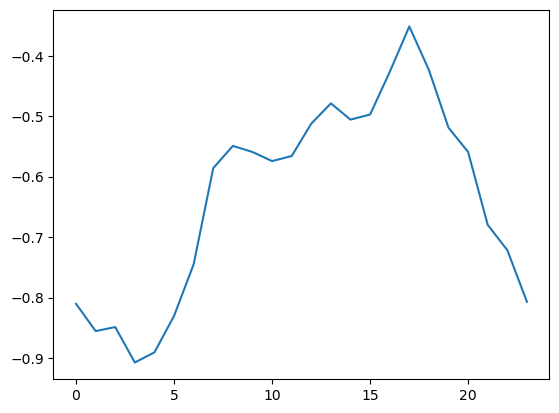

In [148]:
plt.plot(train_dataset[0].y.cpu())

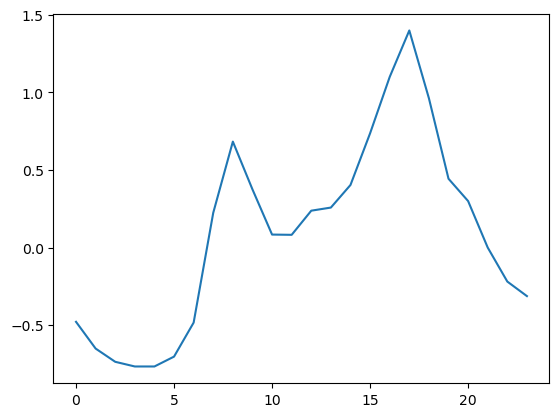

In [149]:
plt.plot(train_dataset[1].y.cpu())

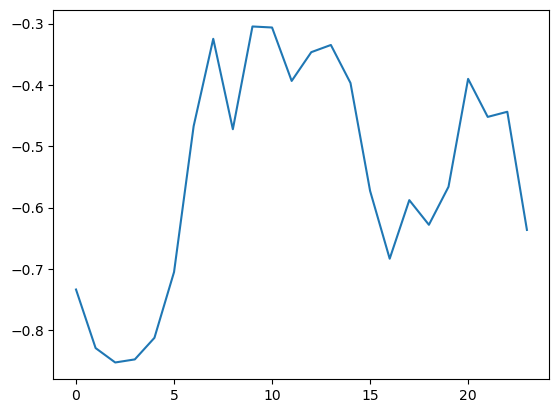

In [150]:
plt.plot(train_dataset[2].y.cpu())

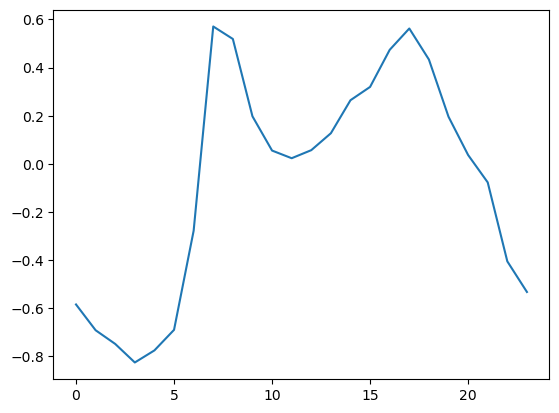

In [151]:
plt.plot(train_dataset[3].y.cpu())

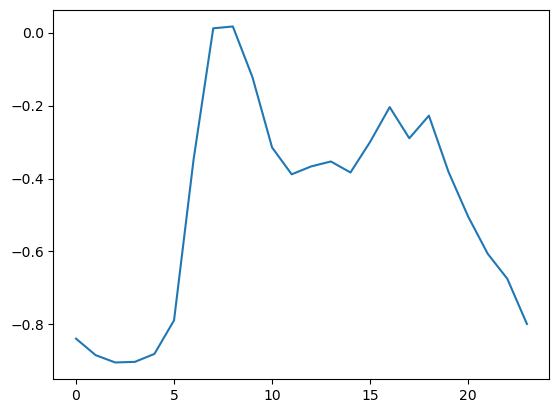

In [152]:
plt.plot(train_dataset[4].y.cpu())

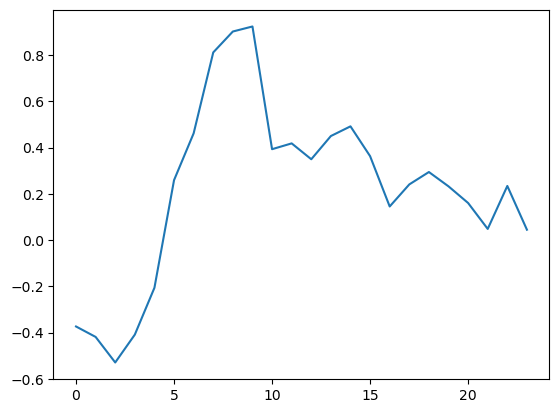

In [153]:
plt.plot(train_dataset[5].y.cpu())

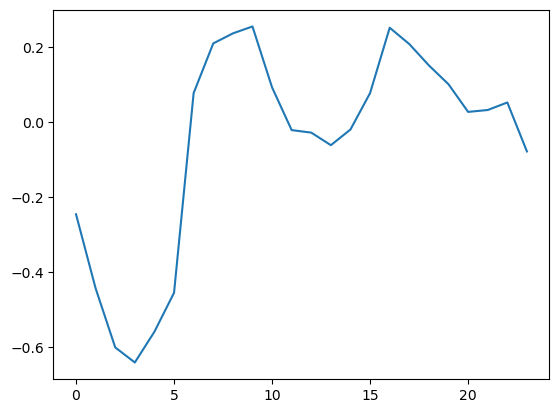

In [154]:
plt.plot(train_dataset[6].y.cpu())

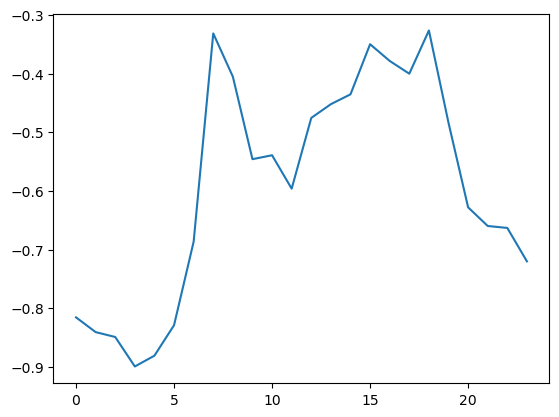

In [155]:
plt.plot(train_dataset[7].y.cpu())

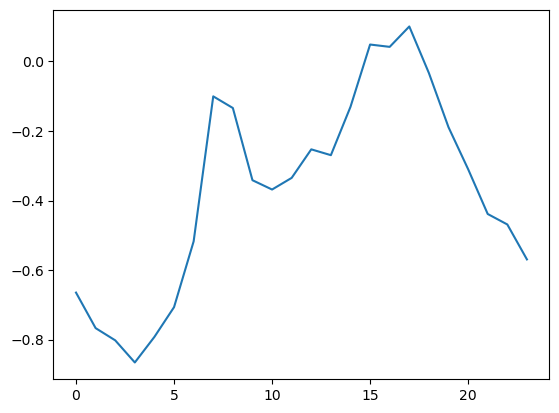

In [156]:
plt.plot(train_dataset[8].y.cpu())

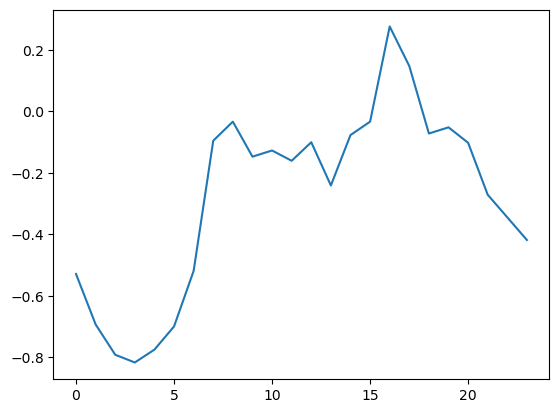

In [157]:
plt.plot(train_dataset[9].y.cpu())